In [81]:
#KÜTÜPHANELERİMİZ

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier 



1. Veri Setini Ekleme: Verimi yükledim ve analize başlamak için hazır hale getirdim.

2. Eksik Verileri Ekleme: Eksik veriler olup olmadığını kontrol ettim ve bunları tamamlamak için uygun yöntemleri (silme veya ortalama ile doldurma) kullandım.

3. grabcolnames Fonksiyonu ile Kategorik ve Sayısal Verileri Bulma: Veri setindeki sayısal ve kategorik değişkenleri belirlemek için bu fonksiyonu kullandım.

4. NaN Verilere Bakma: Veri setimde NaN değerlerini kontrol ettim ve duruma göre bu değerleri ya sildim ya da ortalama değerlerle doldurdum.

5. catsummary ve numsummary Değerlerine Bakma: Kategorik ve sayısal veriler için özet istatistiklere göz attım ve önemli bilgiler edindim.

6. Korelasyona Bakma: Değişkenler arasındaki korelasyonu inceledim ve hangi değişkenlerin daha güçlü ilişkiler sunduğunu değerlendirdim.

7. Aykırı Değerlere Bakma ve Gerekli İşlemleri Yapma: Veri setimdeki aykırı değerlere göz attım ve gerekirse bu değerleri düzelttim.

8. OneHotEncoder ve StandardScaler Uygulama: Kategorik verileri one-hot encoding ile dönüştürdüm ve sayısal verileri ölçeklendirmek için StandardScaler kullandım.

9. Modeli Oluşturma: Veri setimi hazırladıktan sonra bir model oluşturup eğittim.

---

# VERİ SETİ HAKKINDA BİLGİLER


* sex: Kadın için 1, Erkek için 2.
* age: Hastanın yaşı.
* classification: COVID testi bulguları. 1-3 değerleri hastanın COVID hastalığını farklı derecelerde taşıdığını gösterirken, 4 ve üzeri değerler, hastanın COVID taşıyıcısı olmadığını veya testin kesin olmadığı durumları ifade eder.patient type: Hastanın birim içinde aldığı bakım türü. 1, hastanın evine gönderildiğini, 2 ise hastaneye yatırıldığını gösterir.
* pneumonia: Hastanın zatürre olup olmadığı.
* pregnancy: Hastanın hamile olup olmadığı.
* diabetes: Hastanın diyabeti olup olmadığı.
* copd: Hastanın Kronik Obstrüktif Akciğer Hastalığı (KOAH) olup olmadığı.
* asthma: Hastanın astımı olup olmadığı.
* inmsupr: Hastanın bağışıklık sisteminin baskılanmış olup olmadığı.
* hypertension: Hastanın hipertansiyonu olup olmadığı.
* cardiovascular: Hastanın kalp veya damar hastalığı olup olmadığı.
* renal chronic: Hastanın kronik böbrek hastalığı olup olmadığı.
* other disease: Hastanın başka hastalıkları olup olmadığı.obesity: Hastanın obez olup olmadığı.
* tobacco: Hastanın tütün kullanıp kullanmadığı.
* usmr: Hastanın birinci, ikinci veya üçüncü basamaktan bir sağlık biriminde tedavi edilip edilmediği.
* medical unit: Hastaya bakım veren Ulusal Sağlık Sistemi'ne bağlı kurum tipi.
* intubed: Hastanın ventilatöre bağlanıp bağlanmadığı.
* icu: Hastanın Yoğun Bakım Ünitesi'ne (YBÜ) alınıp alınmadığı.date
* died: Hastanın öldüğü tarih. Eğer hasta hayatta ise "9999-99-99" olarak belirtilmiştir.


# ***1.DENEME - BOŞ VERİLERE ORTALAMA DEĞER VEREREK DOLDURMA*** 

In [82]:
df = pd.read_csv("/kaggle/input/covid-19/Covid Data.csv",nrows=200000)      # Yaklaşık 1m satır var ama ben ilk 200k satırı aldım
df.head(5)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [83]:
# Bu kod ile kategorik , sayısal ve kategorik gibi gözüken sayısal verileri buluyoruz
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)


1. cat_cols
Kategorik (string/object tipi) sütunları içerir.

    Örneğin, "City" sütunu (Ankara, İstanbul, İzmir) ve "Gender" sütunu (Male, Female).

2. num_but_cat
Sayısal olup, benzersiz değer sayısı düşük olduğu için kategorik gibi davranan sütunları içerir.

    Örneğin, "Age_Group" sütunu (1, 2, 3 grupları) veya "Binary_Flag" sütunu (0 ve 1 değerleri).

3. cat_but_car
Kategorik görünümlü (object tipi) ancak benzersiz değer sayısı yüksek olduğu için kardinal olan sütunları içerir..

    Örneğin, "Customer_ID" sütunu (her müşteri için eşsiz bir ID) veya "Invoice_Number" sütunu (her fatura için benzersiz bir numara).

4. num_cols
Sayısal sütunları içerir, ancak sayısal olup kategorik davranan sütunları çıkarır.

   Örneğin, "Salary" sütunu (5000, 7000, 10000) ve "Age" sütunu (25, 30, 35).

In [84]:
# NAN VERİ EKLEYELİM
import pandas as pd
import numpy as np
import random

def add_random_missing_values(dataframe: pd.DataFrame,
                              missing_rate: float = 0.05) -> pd.DataFrame:
    """Turns random values to NaN in a DataFrame.

    To use this function, you need to import pandas, numpy and random libraries.

    Args:
        dataframe (pd.DataFrame): DataFrame to be processed.
        missing_rate (float): Percentage of missing value rate in float format. Defaults 0.05

    Returns:
        df_missing (pd.DataFrame): Processed DataFrame object.

    """
    # Get copy of dataframe
    df_missing = dataframe.copy()

    # Obtain size of dataframe and number total number of missing values
    df_size = dataframe.size
    num_missing = int(df_size * missing_rate)

    # Get random row and column indexes to turn them NaN
    for _ in range(num_missing):
        row_idx = random.randint(0, dataframe.shape[0] - 1)
        col_idx = random.randint(0, dataframe.shape[1] - 1)

        df_missing.iat[row_idx, col_idx] = np.nan

    return df_missing

In [85]:
df = add_random_missing_values(df , missing_rate=0.05)
print(df.isnull().sum())

USMER                   9747
MEDICAL_UNIT            9756
SEX                     9810
PATIENT_TYPE            9787
DATE_DIED               9764
INTUBED                 9774
PNEUMONIA               9923
AGE                     9705
PREGNANT                9651
DIABETES                9661
COPD                    9780
ASTHMA                  9877
INMSUPR                 9653
HIPERTENSION            9683
OTHER_DISEASE           9771
CARDIOVASCULAR          9667
OBESITY                 9778
RENAL_CHRONIC           9670
TOBACCO                 9667
CLASIFFICATION_FINAL    9833
ICU                     9685
dtype: int64


In [86]:
from sklearn.impute import SimpleImputer

# Sayısal verileri doldurmak için median yöntemini kullanıyoruz
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Kategorik verileri doldurmak içi most-frequent yöntemini kullanıyoruz
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Tarih verileri doldurmak içi most-frequent yöntemini kullanıyoruz
cat_but_car_imputer = SimpleImputer(strategy="most_frequent")
df[cat_but_car] = cat_but_car_imputer.fit_transform(df[cat_but_car])

In [87]:
# KATEGORİK DEĞİŞKENİN SINIF FREKANSINI VE SINIFLARIN ORANINI VERİR , PLOT TRUE OLURSA GRAFİK VERİR
# KATEGORİK DEĞİŞKENLERİ ÖZETLEMEK İÇİN KULLANILIR
def cat_summary(dataframe,col_name,plot=False):
    print(pd.DataFrame({col_name:dataframe[col_name].value_counts(),
                       "Ratio": 100*dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################################")
    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show(block=True)
# SAYISAL DEĞİŞKENLERİ ÖZETLEMEK İÇİN KULLANILIR
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)



#Hedef değişken (target) ile sayısal bir değişken (numerical_col) arasındaki ilişkiyi özetler.
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
# Kategorik bir sütundaki her bir kategori için hedef değişkenin ortalamasını 
# hesaplayarak hedef değişken ile kategorik değişken arasındaki ilişkiyi özetler.
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

count    200000.000000
mean         45.249720
std          16.840896
min           0.000000
5%           22.000000
10%          26.000000
20%          31.000000
30%          35.000000
40%          40.000000
50%          44.000000
60%          48.000000
70%          53.000000
80%          60.000000
90%          69.000000
95%          76.000000
99%          86.000000
max         107.000000
Name: AGE, dtype: float64


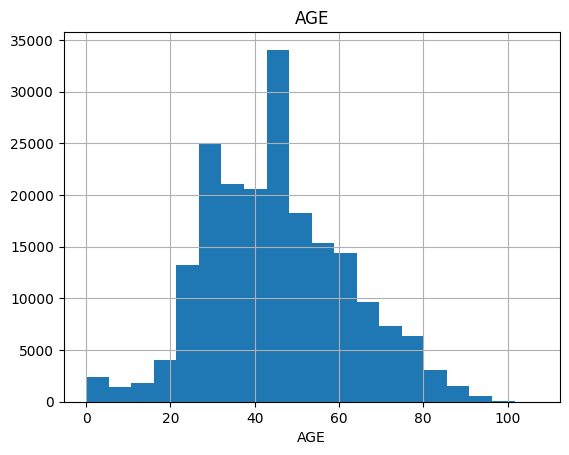

count    200000.000000
mean          3.955965
std           1.495389
min           1.000000
5%            3.000000
10%           3.000000
20%           3.000000
30%           3.000000
40%           3.000000
50%           3.000000
60%           3.000000
70%           5.000000
80%           6.000000
90%           6.000000
95%           7.000000
99%           7.000000
max           7.000000
Name: CLASIFFICATION_FINAL, dtype: float64


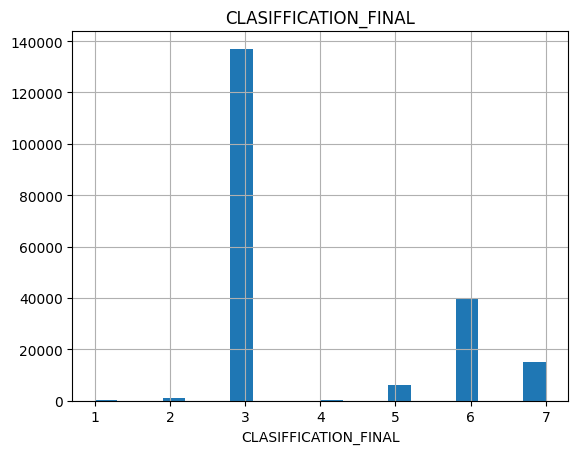

In [88]:
# Sayısal değişkenlerin incelenmesi
for col in num_cols:
    num_summary(df[num_cols],col,plot=True)

In [89]:
# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df[cat_cols], col)

        USMER    Ratio
USMER                 
2.0    116339  58.1695
1.0     83661  41.8305
##########################################################
              MEDICAL_UNIT    Ratio
MEDICAL_UNIT                       
4.0                 181425  90.7125
3.0                  18269   9.1345
2.0                    164   0.0820
1.0                    142   0.0710
##########################################################
        SEX   Ratio
SEX                
2.0  109442  54.721
1.0   90558  45.279
##########################################################
              PATIENT_TYPE   Ratio
PATIENT_TYPE                      
1.0                 134176  67.088
2.0                  65824  32.912
##########################################################
         INTUBED    Ratio
INTUBED                  
97.0      134065  67.0325
2.0        48227  24.1135
1.0        16566   8.2830
99.0        1142   0.5710
##########################################################
           PNEUMONIA 

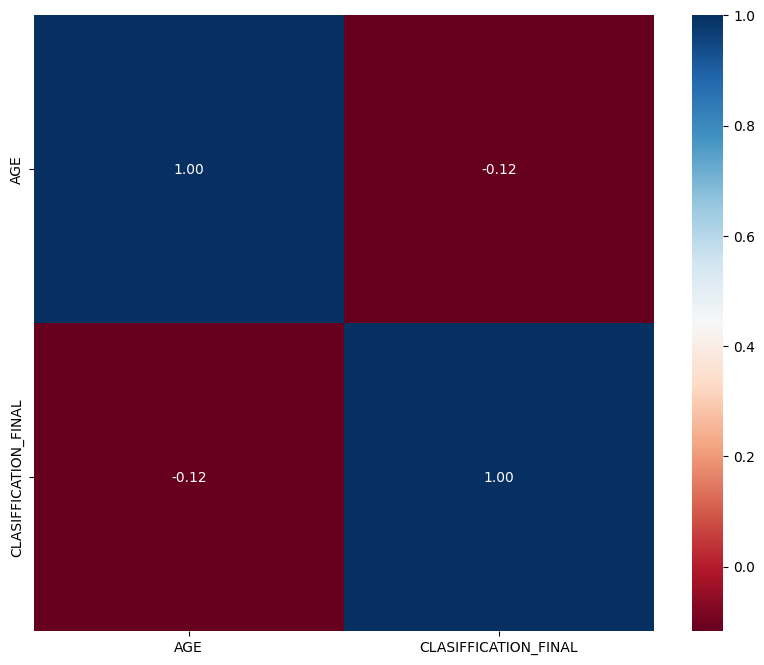

In [90]:
# Korelasyonlarına Bakalım
def correlation_matrix(df, cols):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[cols].corr(), annot=True, fmt=".2f", cmap="RdBu")
    plt.show()

correlation_matrix(df,num_cols)

In [91]:
#Veri tiplerine bakalım
print(df.dtypes)

USMER                   float64
MEDICAL_UNIT            float64
SEX                     float64
PATIENT_TYPE            float64
DATE_DIED                object
INTUBED                 float64
PNEUMONIA               float64
AGE                     float64
PREGNANT                float64
DIABETES                float64
COPD                    float64
ASTHMA                  float64
INMSUPR                 float64
HIPERTENSION            float64
OTHER_DISEASE           float64
CARDIOVASCULAR          float64
OBESITY                 float64
RENAL_CHRONIC           float64
TOBACCO                 float64
CLASIFFICATION_FINAL    float64
ICU                     float64
dtype: object


 ---
 # AYKIRI DEĞERLER

In [92]:
#aykırı değerlerin sınır değerlerini bulmaya yarar
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)  # Quartile 1 (Q1)
    quartile3 = dataframe[col_name].quantile(q3)  # Quartile 3 (Q3)
    interquartile_range = quartile3 - quartile1  # IQR (Interquartile Range)
    
    up_limit = quartile3 + 1.5 * interquartile_range  # Upper limit
    low_limit = quartile1 - 1.5 * interquartile_range  # Lower limit
    
    return low_limit, up_limit


In [93]:
# aykırı değerleri sınır değerine eşitler
def replace_with_thresholds(dataframe,veriable):
    low_limit,up_limit = outlier_thresholds(dataframe,veriable)
    dataframe.loc[(dataframe[veriable] < low_limit), veriable] = low_limit
    dataframe.loc[(dataframe[veriable] > up_limit), veriable] = up_limit

In [94]:
# aykırı değer var mı ? Kontrol edelim
def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [95]:
# Aykırı değer var mı ?  kontrol edelim
for col in num_cols:
    print(col, check_outlier(df, col, 0.25, 0.75))

AGE True
CLASIFFICATION_FINAL False


In [96]:
replace_with_thresholds(df, "AGE")
# Aykırı değerleri sınır değerlerine eşitleyelim - istersek silebiliriz ama ben sınıra eşitmeke istedim

In [97]:
# Aykırı değer var mı ?  kontrol edelim
for col in num_cols:
    print(col, check_outlier(df, col, 0.25, 0.75))

AGE False
CLASIFFICATION_FINAL False


In [98]:
# Aykırı değer var mı ?  kontrol edelim
for col in cat_cols:
    print(col, check_outlier(df, col, 0.25, 0.75))

USMER False
MEDICAL_UNIT True
SEX False
PATIENT_TYPE False
INTUBED False
PNEUMONIA True
PREGNANT False
DIABETES True
COPD True
ASTHMA True
INMSUPR True
HIPERTENSION True
OTHER_DISEASE True
CARDIOVASCULAR True
OBESITY True
RENAL_CHRONIC True
TOBACCO True
ICU False


In [99]:
replace_with_thresholds(df, "MEDICAL_UNIT")
replace_with_thresholds(df, "COPD")
replace_with_thresholds(df, "PNEUMONIA")
replace_with_thresholds(df, "DIABETES")
replace_with_thresholds(df, "ASTHMA")
replace_with_thresholds(df, "INMSUPR")
replace_with_thresholds(df, "HIPERTENSION")       # AYKIRI DEĞERLERİ SINIR DEĞERİNE EŞİTLİYOR 
replace_with_thresholds(df, "OTHER_DISEASE")
replace_with_thresholds(df, "CARDIOVASCULAR")
replace_with_thresholds(df, "OBESITY")
replace_with_thresholds(df, "RENAL_CHRONIC")
replace_with_thresholds(df, "TOBACCO")

for col in cat_cols:
    print(col, check_outlier(df, col, 0.25, 0.75))




USMER False
MEDICAL_UNIT False
SEX False
PATIENT_TYPE False
INTUBED False
PNEUMONIA False
PREGNANT False
DIABETES False
COPD False
ASTHMA False
INMSUPR False
HIPERTENSION False
OTHER_DISEASE False
CARDIOVASCULAR False
OBESITY False
RENAL_CHRONIC False
TOBACCO False
ICU False


--- 
# AYKIRI DEĞERLERİ HALLETTİK ŞİMDİ NORMAL İŞLEMLERE GEÇEBİLİRİZ

In [100]:
# Classification datamızda birsürü değişken var ve bu yüzden sınıflandırma yapamayız ancak tahmin işlemleri yaparız
# Bunu düzeltmek için yeni değişken oluşturalım
# 1: COVID Pozitif (1, 2, 3)
# 0: COVID Negatif/Belirsiz (4 ve üzeri)

df["COVID_STATUS"] = np.where(df["CLASIFFICATION_FINAL"]<= 3,1,0)
#Anlamı 3 veya daha küçükse 1 atanır  ama 4 veya daha büyükse 0 atanır 
# COVID_STATUS değişkenini kontrol edelim
print(df['COVID_STATUS'].value_counts())

COVID_STATUS
1    138552
0     61448
Name: count, dtype: int64


In [101]:
#Onehot encoder amacı kategorik verileri sayısallaştırmak
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    # One-Hot Encoding işlemi
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
df = one_hot_encoder(df, cat_cols, drop_first=True)
df = one_hot_encoder(df, cat_but_car, drop_first=True)

In [102]:
# StandardScaler'ın amacı, sayısal verilerin dağılımlarını standartlaştırmak yani ortalama (mean) ve standart sapma (standard deviation)
# kullanarak verileri standart normal dağılıma dönüştürür
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled,columns=df[num_cols].columns,index=df.index)

# Numy dizisini , Pandas DataFrame'e dönüştürürken orijinal satır indekslerini korumak için index=df.index parametresini kulanabiliriz

In [103]:
print(df['COVID_STATUS'].value_counts()) # eşsiz değerlerin sayısına bakalım

COVID_STATUS
1    138552
0     61448
Name: count, dtype: int64


In [104]:
print(df.isnull().sum())  #Boş veri var mı bakalım

AGE                     0
CLASIFFICATION_FINAL    0
COVID_STATUS            0
USMER_2.0               0
SEX_2.0                 0
                       ..
DATE_DIED_31/03/2020    0
DATE_DIED_31/05/2020    0
DATE_DIED_31/07/2020    0
DATE_DIED_31/08/2020    0
DATE_DIED_9999-99-99    0
Length: 348, dtype: int64


In [105]:
print(df.nunique())   # Eşsiz değerlerin sayısına bakalım


AGE                     92
CLASIFFICATION_FINAL     7
COVID_STATUS             2
USMER_2.0                2
SEX_2.0                  2
                        ..
DATE_DIED_31/03/2020     2
DATE_DIED_31/05/2020     2
DATE_DIED_31/07/2020     2
DATE_DIED_31/08/2020     2
DATE_DIED_9999-99-99     2
Length: 348, dtype: int64


In [106]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

X = df.drop(["COVID_STATUS"],axis=1)
y = df["COVID_STATUS"]

model = LogisticRegression(max_iter=500) # İterasyon modelin parametrelerini (ağırlıklarını) güncelleme süreci
cv_scores = cross_val_score(model,X,y,cv=5,scoring="accuracy")

print("Boş Verilerin Yerine Ortalama Değerler İle Doldurduğumuzda Çıkan Sonuç : ",np.mean(cv_scores))

Boş Verilerin Yerine Ortalama Değerler İle Doldurduğumuzda Çıkan Sonuç :  0.999085


---
---
---

# ***2.DENEME - BOŞ VERİLERİ SİLEREK İŞLEM YAPMA*** 

In [107]:
df1 = pd.read_csv("/kaggle/input/covid-19/Covid Data.csv",nrows=200000)      # Yaklaşık 1m satır var ama ben ilk 200k satırı aldım
df1.head(5)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [108]:
# Bu kod ile kategorik , sayısal ve kategorik gibi gözüken sayısal verileri buluyoruz
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df1, cat_th=5, car_th=20)


In [109]:
# Nan verileri ekleyelim
def add_random_missing_values(dataframe: pd.DataFrame,
                              missing_rate: float = 0.05) -> pd.DataFrame:
    """Turns random values to NaN in a DataFrame.

    To use this function, you need to import pandas, numpy and random libraries.

    Args:
        dataframe (pd.DataFrame): DataFrame to be processed.
        missing_rate (float): Percentage of missing value rate in float format. Defaults 0.05

    Returns:
        df_missing (pd.DataFrame): Processed DataFrame object.

    """
    # Get copy of dataframe
    df_missing = dataframe.copy()

    # Obtain size of dataframe and number total number of missing values
    df_size = dataframe.size
    num_missing = int(df_size * missing_rate)

    # Get random row and column indexes to turn them NaN
    for _ in range(num_missing):
        row_idx = random.randint(0, dataframe.shape[0] - 1)
        col_idx = random.randint(0, dataframe.shape[1] - 1)

        df_missing.iat[row_idx, col_idx] = np.nan

    return df_missing

In [110]:
df1 = add_random_missing_values(df1 , missing_rate=0.05)
print(df1.isnull().sum())

USMER                   9723
MEDICAL_UNIT            9863
SEX                     9751
PATIENT_TYPE            9820
DATE_DIED               9925
INTUBED                 9841
PNEUMONIA               9792
AGE                     9575
PREGNANT                9725
DIABETES                9698
COPD                    9687
ASTHMA                  9677
INMSUPR                 9807
HIPERTENSION            9714
OTHER_DISEASE           9584
CARDIOVASCULAR          9844
OBESITY                 9807
RENAL_CHRONIC           9781
TOBACCO                 9636
CLASIFFICATION_FINAL    9801
ICU                     9738
dtype: int64


In [111]:
# BOŞ VERİLERİ EKLEDİK AMA BEN SİLEREK DENEMEK İSTİYORUM
# Yalnızca özelliklerdeki eksik verileri silme
# COVID_STATUS haricindeki tüm sütunlarda eksik verileri silme
df1 = df1.dropna() 

In [112]:
# KATEGORİK DEĞİŞKENİN SINIF FREKANSINI VE SINIFLARIN ORANINI VERİR , PLOT TRUE OLURSA GRAFİK VERİR
# KATEGORİK DEĞİŞKENLERİ ÖZETLEMEK İÇİN KULLANILIR
def cat_summary(dataframe,col_name,plot=False):
    print(pd.DataFrame({col_name:dataframe[col_name].value_counts(),
                       "Ratio": 100*dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################################")
    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show(block=True)
# SAYISAL DEĞİŞKENLERİ ÖZETLEMEK İÇİN KULLANILIR
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)



#Hedef değişken (target) ile sayısal bir değişken (numerical_col) arasındaki ilişkiyi özetler.
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
# Kategorik bir sütundaki her bir kategori için hedef değişkenin ortalamasını 
# hesaplayarak hedef değişken ile kategorik değişken arasındaki ilişkiyi özetler.
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

count    70051.000000
mean        45.329703
std         17.269792
min          0.000000
5%          21.000000
10%         26.000000
20%         30.000000
30%         35.000000
40%         39.000000
50%         44.000000
60%         49.000000
70%         54.000000
80%         60.000000
90%         70.000000
95%         76.000000
99%         86.000000
max        102.000000
Name: AGE, dtype: float64


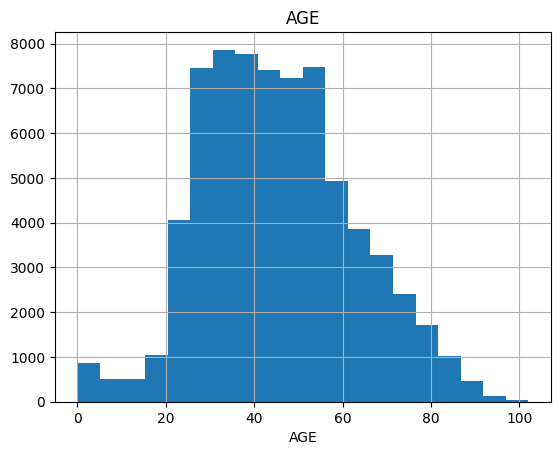

count    70051.000000
mean         4.010607
std          1.518194
min          1.000000
5%           3.000000
10%          3.000000
20%          3.000000
30%          3.000000
40%          3.000000
50%          3.000000
60%          3.000000
70%          5.000000
80%          6.000000
90%          6.000000
95%          7.000000
99%          7.000000
max          7.000000
Name: CLASIFFICATION_FINAL, dtype: float64


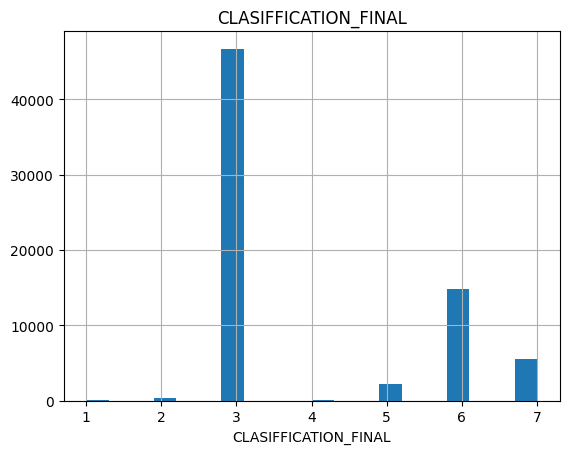

In [113]:
for col in num_cols:
    num_summary(df1[num_cols],col,plot=True)

In [114]:
# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df1[cat_cols], col)

       USMER     Ratio
USMER                 
2.0    39459  56.32896
1.0    30592  43.67104
##########################################################
              MEDICAL_UNIT      Ratio
MEDICAL_UNIT                         
4.0                  63184  90.197142
3.0                   6749   9.634409
2.0                     64   0.091362
1.0                     54   0.077087
##########################################################
       SEX      Ratio
SEX                  
2.0  36605  52.254786
1.0  33446  47.745214
##########################################################
              PATIENT_TYPE      Ratio
PATIENT_TYPE                         
1.0                  45963  65.613624
2.0                  24088  34.386376
##########################################################
         INTUBED      Ratio
INTUBED                    
97.0       45963  65.613624
2.0        17580  25.096001
1.0         6122   8.739347
99.0         386   0.551027
####################################

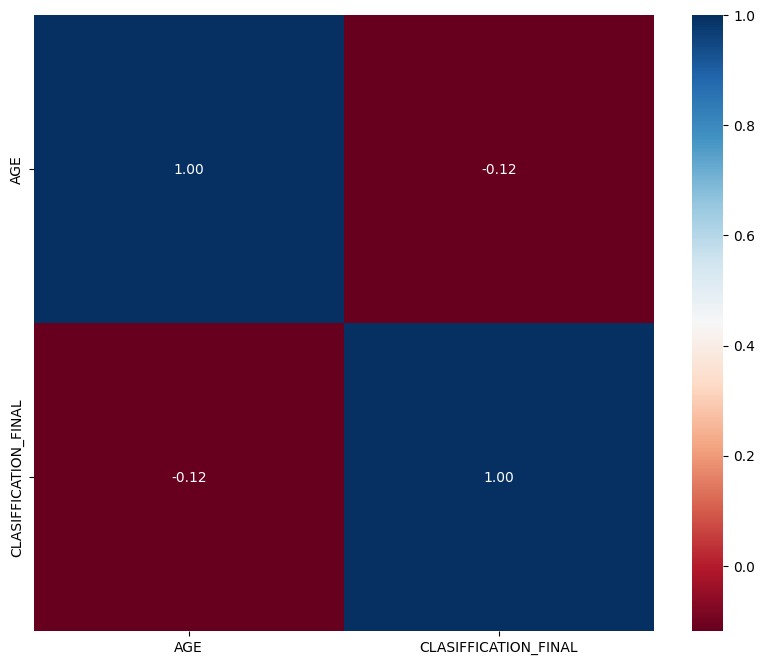

In [115]:
# Korelasyonlarına Bakalım
def correlation_matrix(df, cols):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[cols].corr(), annot=True, fmt=".2f", cmap="RdBu")
    plt.show()

correlation_matrix(df1,num_cols)

In [116]:
print(df1.isnull().sum())

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DATE_DIED               0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64


---
# AYKIRI DEĞERLERE BAKALIM TEKRARDAN

In [117]:
#aykırı değerlerin sınır değerlerini bulmaya yarar
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)  # Quartile 1 (Q1)
    quartile3 = dataframe[col_name].quantile(q3)  # Quartile 3 (Q3)
    interquartile_range = quartile3 - quartile1  # IQR (Interquartile Range)
    
    up_limit = quartile3 + 1.5 * interquartile_range  # Upper limit
    low_limit = quartile1 - 1.5 * interquartile_range  # Lower limit
    
    return low_limit, up_limit


In [118]:
# aykırı değerleri sınır değerine eşitler
def replace_with_thresholds(dataframe,veriable):
    low_limit,up_limit = outlier_thresholds(dataframe,veriable)
    dataframe.loc[(dataframe[veriable] < low_limit), veriable] = low_limit
    dataframe.loc[(dataframe[veriable] > up_limit), veriable] = up_limit

In [119]:
# aykırı değer var mı ? Kontrol edelim
def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [120]:
# Aykırı değer var mı ?  kontrol edelim
for col in num_cols:
    print(col, check_outlier(df1, col, 0.25, 0.75))

AGE True
CLASIFFICATION_FINAL False


In [121]:
# Aykırı değer var mı ?  kontrol edelim
for col in cat_cols:
    print(col, check_outlier(df1, col, 0.25, 0.75))

USMER False
MEDICAL_UNIT True
SEX False
PATIENT_TYPE False
INTUBED False
PNEUMONIA True
PREGNANT False
DIABETES True
COPD True
ASTHMA True
INMSUPR True
HIPERTENSION True
OTHER_DISEASE True
CARDIOVASCULAR True
OBESITY True
RENAL_CHRONIC True
TOBACCO True
ICU False


In [122]:
replace_with_thresholds(df1, "AGE")

In [123]:
replace_with_thresholds(df1, "MEDICAL_UNIT")
replace_with_thresholds(df1, "COPD")
replace_with_thresholds(df1, "PNEUMONIA")
replace_with_thresholds(df1, "DIABETES")
replace_with_thresholds(df1, "ASTHMA")
replace_with_thresholds(df1, "INMSUPR")
replace_with_thresholds(df1, "HIPERTENSION")       # AYKIRI DEĞERLERİ SINIR DEĞERİNE EŞİTLİYOR 
replace_with_thresholds(df1, "OTHER_DISEASE")
replace_with_thresholds(df1, "CARDIOVASCULAR")
replace_with_thresholds(df1, "OBESITY")
replace_with_thresholds(df1, "RENAL_CHRONIC")
replace_with_thresholds(df1, "TOBACCO")

for col in cat_cols:
    print(col, check_outlier(df1, col, 0.25, 0.75))

USMER False
MEDICAL_UNIT False
SEX False
PATIENT_TYPE False
INTUBED False
PNEUMONIA False
PREGNANT False
DIABETES False
COPD False
ASTHMA False
INMSUPR False
HIPERTENSION False
OTHER_DISEASE False
CARDIOVASCULAR False
OBESITY False
RENAL_CHRONIC False
TOBACCO False
ICU False


---

In [124]:
# Kategorik verileri sayısallaştıralım
def one_hot_encoder(dataframe,categorical_cols,drop_first=False):
    dataframe = pd.get_dummies(dataframe,columns=categorical_cols,drop_first=drop_first)
    return dataframe
df1 = one_hot_encoder(df1,cat_cols,drop_first=True)
df1 = one_hot_encoder(df1,cat_but_car,drop_first=True)

In [125]:
from sklearn.preprocessing import StandardScaler
# Kısaca sayısal verilerin alanlarını küçültmeeye yarar ki daha iyi sınıflandırma yapabilelim
X_scaled = StandardScaler().fit_transform(df1[num_cols])
df1[num_cols] = pd.DataFrame(df1,columns=df1[num_cols].columns,index=df1.index)
#   pd.DataFrame(df1  buraya X_scaled yazarsam NaN veriler çıkıyor ama df1 yazınca çıkmıyor nedeninin anlayamadım
#   dropna ile sildiğim için yapıyor sanırım


# index=df1.index: DataFrame'in indekslerini koruyarak hatalı bir eşleştirme olmasını önler
# çünkü bu kod olmazsa yeni boş veriler çıkıyor

In [126]:
print(df1[num_cols].isnull().sum())  # Numarik sütunlardaki eksik verileri kontrol et


AGE                     0
CLASIFFICATION_FINAL    0
dtype: int64


In [127]:
# CLASIFFICATION_FINAL sütununu kullanarak COVID_STATUS hedef değişkenini oluşturma
df1["COVID_STATUS"] = np.where(df1["CLASIFFICATION_FINAL"]<= 3,1,0)  # ANLAMI 1 VE 3 ARASINDA OLMAYAN DEĞERLER 0 OLARAK ATANICAK
# 1: COVID Pozitif (1, 2, 3)
# 0: COVID Negatif/Belirsiz (4 ve üzeri)

# eşsiz değerlerin sayısına bakalım
print(df1["COVID_STATUS"].value_counts())


COVID_STATUS
1    47283
0    22768
Name: count, dtype: int64


In [128]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

X = df1.drop(["COVID_STATUS"],axis=1)
y= df1["COVID_STATUS"]
model = LogisticRegression(max_iter=500)
cv_scores = cross_val_score(model,X,y,cv=5,scoring="accuracy")

print("Verileri Sildiğimiz Zaman Çıkan Sonuç :",np.mean(cv_scores))


Verileri Sildiğimiz Zaman Çıkan Sonuç : 0.9992291770751554


# 

---
---
# **VERİ SETİMİZDEKİ VERİLERİN ORTALAMA DEĞERLERİNİ ALARAK VE**
# **BOŞ DEĞERLERİNİ SİLEREK 2 MODEL YAPTIK**

# **ŞİMDİ ANA MODELİMİZE GEÇEBİLİRİZ**

In [129]:
df2 = pd.read_csv("/kaggle/input/covid-19/Covid Data.csv",nrows=5000)      # Yaklaşık 1m satır var ama ben ilk 20bin satırı aldım
df2.head(5)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


# VERİSETİNDEN 5000 SATIR ALIYORUM 

5000 ALMAMIN SEBEBİ BU MODELDE 3-4 FARKLI MODELİN SONUÇLARINI ALIYORUM

In [130]:
# Bu kod ile kategorik , sayısal ve kategorik gibi gözüken sayısal verileri buluyoruz
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df2, cat_th=5, car_th=20)


In [131]:
# NAN VERİ EKLEYELİM
import pandas as pd
import numpy as np
import random

def add_random_missing_values(dataframe: pd.DataFrame,
                              missing_rate: float = 0.05) -> pd.DataFrame:
    """Turns random values to NaN in a DataFrame.

    To use this function, you need to import pandas, numpy and random libraries.

    Args:
        dataframe (pd.DataFrame): DataFrame to be processed.
        missing_rate (float): Percentage of missing value rate in float format. Defaults 0.05

    Returns:
        df_missing (pd.DataFrame): Processed DataFrame object.

    """
    # Get copy of dataframe
    df_missing = dataframe.copy()

    # Obtain size of dataframe and number total number of missing values
    df_size = dataframe.size
    num_missing = int(df_size * missing_rate)

    # Get random row and column indexes to turn them NaN
    for _ in range(num_missing):
        row_idx = random.randint(0, dataframe.shape[0] - 1)
        col_idx = random.randint(0, dataframe.shape[1] - 1)

        df_missing.iat[row_idx, col_idx] = np.nan

    return df_missing

In [132]:
df2 = add_random_missing_values(df2 , missing_rate=0.05)
print(df2.isnull().sum())

USMER                   250
MEDICAL_UNIT            242
SEX                     231
PATIENT_TYPE            239
DATE_DIED               227
INTUBED                 254
PNEUMONIA               264
AGE                     253
PREGNANT                240
DIABETES                254
COPD                    238
ASTHMA                  256
INMSUPR                 267
HIPERTENSION            224
OTHER_DISEASE           240
CARDIOVASCULAR          263
OBESITY                 218
RENAL_CHRONIC           261
TOBACCO                 231
CLASIFFICATION_FINAL    234
ICU                     247
dtype: int64


In [133]:
df2.head(15)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2.0,1.0,1.0,1.0,03/05/2020,97.0,1.0,65.0,2.0,2.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,97.0
1,2.0,1.0,NaN,1.0,03/06/2020,97.0,1.0,72.0,97.0,2.0,...,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,5.0,97.0
2,2.0,1.0,2.0,2.0,09/06/2020,1.0,2.0,55.0,97.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0
3,2.0,1.0,1.0,1.0,12/06/2020,97.0,2.0,53.0,2.0,2.0,...,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,7.0,97.0
4,2.0,1.0,2.0,1.0,21/06/2020,97.0,NaN,68.0,97.0,1.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,97.0
5,2.0,1.0,1.0,2.0,9999-99-99,2.0,1.0,40.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,3.0,NaN
6,2.0,1.0,1.0,1.0,9999-99-99,97.0,2.0,64.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,97.0
7,2.0,1.0,1.0,1.0,NaN,97.0,1.0,64.0,2.0,1.0,...,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,3.0,97.0
8,2.0,1.0,NaN,2.0,9999-99-99,2.0,2.0,37.0,2.0,1.0,...,2.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,3.0,2.0
9,2.0,1.0,1.0,2.0,9999-99-99,2.0,2.0,NaN,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0


In [134]:
from sklearn.impute import SimpleImputer
# Sayısal veriler için SimpleImputer kullanarak medyan ile doldurma
num_imputer = SimpleImputer(strategy="median")
df2[num_cols] = num_imputer.fit_transform(df2[num_cols])

# Kategorik veriler için SimpleImputer kullanarak mod ile doldurma
cat_imputer = SimpleImputer(strategy="most_frequent")
df2[cat_cols] = cat_imputer.fit_transform(df2[cat_cols])

# Tarih verileri doldurmak içi most-frequent yöntemini kullanıyoruz
cat_but_car_imputer = SimpleImputer(strategy="most_frequent")
df2[cat_but_car] = cat_but_car_imputer.fit_transform(df2[cat_but_car])

count    5000.000000
mean       48.630600
std        17.182828
min         0.000000
5%         23.000000
10%        28.000000
20%        34.000000
30%        40.000000
40%        45.000000
50%        48.000000
60%        52.000000
70%        57.000000
80%        63.000000
90%        72.000000
95%        78.000000
99%        87.000000
max       103.000000
Name: AGE, dtype: float64


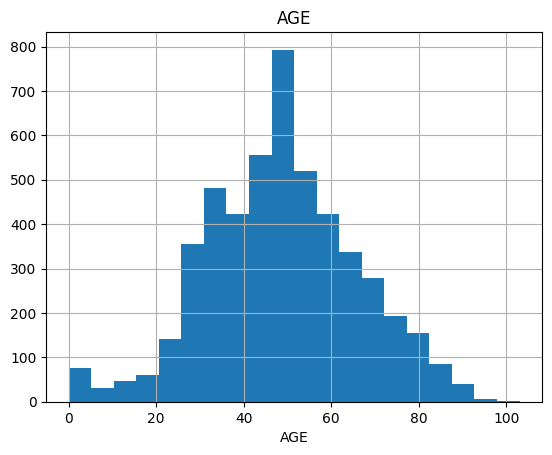

count    5000.000000
mean        3.352400
std         1.205199
min         1.000000
5%          3.000000
10%         3.000000
20%         3.000000
30%         3.000000
40%         3.000000
50%         3.000000
60%         3.000000
70%         3.000000
80%         3.000000
90%         5.000000
95%         7.000000
99%         7.000000
max         7.000000
Name: CLASIFFICATION_FINAL, dtype: float64


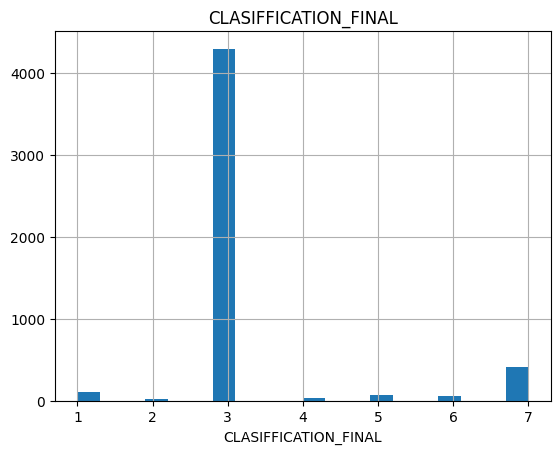

In [135]:
# KATEGORİK DEĞİŞKENİN SINIF FREKANSINI VE SINIFLARIN ORANINI VERİR , PLOT TRUE OLURSA GRAFİK VERİR
# KATEGORİK DEĞİŞKENLERİ ÖZETLEMEK İÇİN KULLANILIR
def cat_summary(dataframe,col_name,plot=False):
    print(pd.DataFrame({col_name:dataframe[col_name].value_counts(),
                       "Ratio": 100*dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################################")
    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show(block=True)
# SAYISAL DEĞİŞKENLERİ ÖZETLEMEK İÇİN KULLANILIR
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)



#Hedef değişken (target) ile sayısal bir değişken (numerical_col) arasındaki ilişkiyi özetler.
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
# Kategorik bir sütundaki her bir kategori için hedef değişkenin ortalamasını 
# hesaplayarak hedef değişken ile kategorik değişken arasındaki ilişkiyi özetler.
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in num_cols:
    num_summary(df2[num_cols],col,plot=True)

In [136]:
# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df2[cat_cols], col)

       USMER  Ratio
USMER              
1.0     2859  57.18
2.0     2141  42.82
##########################################################
              MEDICAL_UNIT  Ratio
MEDICAL_UNIT                     
3.0                   4694  93.88
2.0                    163   3.26
1.0                    143   2.86
##########################################################
      SEX  Ratio
SEX             
2.0  2757  55.14
1.0  2243  44.86
##########################################################
              PATIENT_TYPE  Ratio
PATIENT_TYPE                     
1.0                   2763  55.26
2.0                   2237  44.74
##########################################################
         INTUBED  Ratio
INTUBED                
97.0        2775  55.50
2.0         1567  31.34
1.0          567  11.34
99.0          91   1.82
##########################################################
           PNEUMONIA  Ratio
PNEUMONIA                  
2.0             2898  57.96
1.0             2084  4

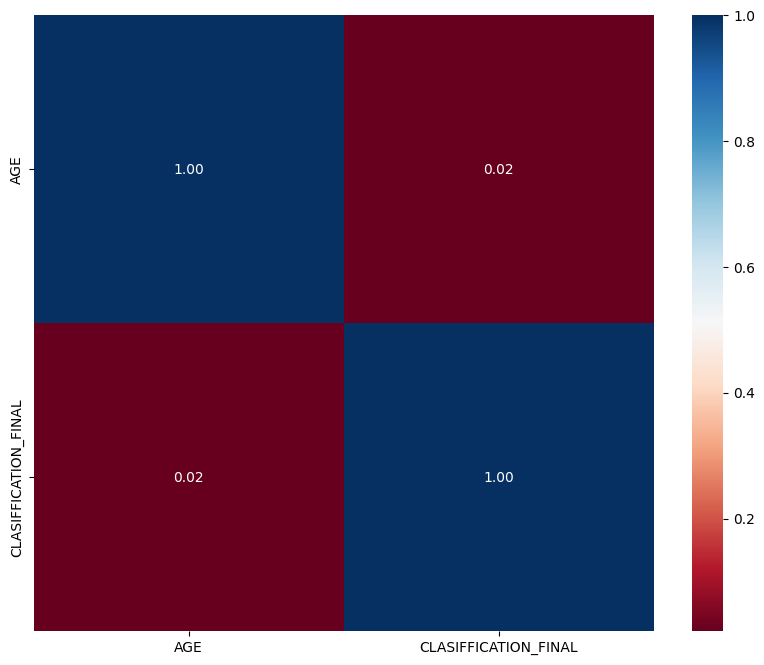

In [137]:
# Korelasyonlarına Bakalım
def correlation_matrix(df, cols):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[cols].corr(), annot=True, fmt=".2f", cmap="RdBu")
    plt.show()

correlation_matrix(df2,num_cols)

---
# AYKIRI DEĞERLERE BAKALIM

In [138]:
#aykırı değerlerin sınır değerlerini bulmaya yarar
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)  # Quartile 1 (Q1)
    quartile3 = dataframe[col_name].quantile(q3)  # Quartile 3 (Q3)
    interquartile_range = quartile3 - quartile1  # IQR (Interquartile Range)
    
    up_limit = quartile3 + 1.5 * interquartile_range  # Upper limit
    low_limit = quartile1 - 1.5 * interquartile_range  # Lower limit
    
    return low_limit, up_limit

In [139]:
# aykırı değerleri sınır değerine eşitler
def replace_with_thresholds(dataframe,veriable):
    low_limit,up_limit = outlier_thresholds(dataframe,veriable)
    dataframe.loc[(dataframe[veriable] < low_limit), veriable] = low_limit
    dataframe.loc[(dataframe[veriable] > up_limit), veriable] = up_limit

In [140]:
# aykırı değer var mı ? Kontrol edelim
def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [141]:
# Aykırı değer var mı ?  kontrol edelim
for col in num_cols:
    print(col, check_outlier(df2, col, 0.25, 0.75))

AGE True
CLASIFFICATION_FINAL True


In [142]:
# Aykırı değer var mı ?  kontrol edelim
for col in cat_cols:
    print(col, check_outlier(df2, col, 0.25, 0.75))

USMER False
MEDICAL_UNIT True
SEX False
PATIENT_TYPE False
INTUBED False
PNEUMONIA True
PREGNANT False
DIABETES True
COPD True
ASTHMA True
INMSUPR True
HIPERTENSION True
OTHER_DISEASE True
CARDIOVASCULAR True
OBESITY True
RENAL_CHRONIC True
TOBACCO True
ICU False


In [143]:
replace_with_thresholds(df2, "AGE")

replace_with_thresholds(df2, "MEDICAL_UNIT")
replace_with_thresholds(df2, "COPD")
replace_with_thresholds(df2, "PNEUMONIA")
replace_with_thresholds(df2, "DIABETES")
replace_with_thresholds(df2, "ASTHMA")
replace_with_thresholds(df2, "INMSUPR")
replace_with_thresholds(df2, "HIPERTENSION")       # AYKIRI DEĞERLERİ SINIR DEĞERİNE EŞİTLİYOR 
replace_with_thresholds(df2, "OTHER_DISEASE")
replace_with_thresholds(df2, "CARDIOVASCULAR")
replace_with_thresholds(df2, "OBESITY")
replace_with_thresholds(df2, "RENAL_CHRONIC")
replace_with_thresholds(df2, "TOBACCO")

for col in cat_cols:
    print(col, check_outlier(df2, col, 0.25, 0.75))

USMER False
MEDICAL_UNIT False
SEX False
PATIENT_TYPE False
INTUBED False
PNEUMONIA False
PREGNANT False
DIABETES False
COPD False
ASTHMA False
INMSUPR False
HIPERTENSION False
OTHER_DISEASE False
CARDIOVASCULAR False
OBESITY False
RENAL_CHRONIC False
TOBACCO False
ICU False


---
# MODELE DÖNELİM

In [144]:
# CLASIFFICATION_FINAL sütununu kullanarak COVID_STATUS hedef değişkenini oluşturma
# 1: COVID Pozitif (1, 2, 3)
# 0: COVID Negatif/Belirsiz (4 ve üzeri)

df2["COVID_STATUS"] = np.where(df2["CLASIFFICATION_FINAL"]<= 3,1,0)  # ANLAMI 1 VE 3 ARASINDA OLMAYAN DEĞERLER 0 OLARAK ATANICAK

# COVID_STATUS değişkenini kontrol etmek için
print(df2['COVID_STATUS'].value_counts())

COVID_STATUS
1    4424
0     576
Name: count, dtype: int64


In [145]:
def one_hot_encoder(dataframe,categorical_cols,drop_first=False):
    dataframe = pd.get_dummies(dataframe,columns=categorical_cols,drop_first=drop_first)
    return dataframe
df2 = one_hot_encoder(df2,cat_cols,drop_first=True)
df2 = one_hot_encoder(df2,cat_but_car,drop_first=True)


In [146]:
X_scaled = StandardScaler().fit_transform(df2[num_cols])
df2[num_cols] = pd.DataFrame(X_scaled,columns=df2[num_cols].columns,index=df2.index)

In [147]:
print(df2['COVID_STATUS'].value_counts())

COVID_STATUS
1    4424
0     576
Name: count, dtype: int64


In [148]:
print(df2.isnull().sum())

AGE                     0
CLASIFFICATION_FINAL    0
COVID_STATUS            0
USMER_2.0               0
SEX_2.0                 0
                       ..
DATE_DIED_30/06/2020    0
DATE_DIED_30/07/2020    0
DATE_DIED_31/05/2020    0
DATE_DIED_31/07/2020    0
DATE_DIED_9999-99-99    0
Length: 176, dtype: int64


In [149]:
y = df2["COVID_STATUS"]
X = df2.drop(["COVID_STATUS"], axis=1)

In [150]:
def base_models(X,y,scoring="roc_auc"):
    print("Modeller İşleniyor Lütfen Bekleyin...")
    classifiers=[("LR",LogisticRegression()),
                ("KNN",KNeighborsClassifier()),
                ("SVC",SVC()),
                ("RF",RandomForestClassifier()),
                ("Adaboost",AdaBoostClassifier()),
                ("GBM",GradientBoostingClassifier()),
                ('XGBoost', XGBClassifier(eval_metric='logloss'))]
    for name,classifier in classifiers:
        cv_results = cross_validate(classifier,X,y,cv=10,scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

# MODELLERİ HİPERPARAMETRE EDELİM
# VEYA BUNUN YERİNE GRİDSEARCH GİBİ ALGORİTMALARI KULLANABİLİRİZ

#log_params = {
#    "penalty": ["l1", "l2", "elasticnet"],  # Cezalandırma türleri (overfitting engellemek amacıyla kullanılır)
#    "C": [0.01, 0.1, 1, 10],                 # Regularizasyon güçleri - Model, veriye tam uyum sağlamaktan kaçınır, böylece overfitting (aşırı uyum) riski azalır.
#    "solver": ["lbfgs", "liblinear", "saga"],      # Optimizasyon çözücüleri - modelin optimizasyon algoritmasını belirler
#    "max_iter": [500]   }           # Maksimum iterasyon sayıları - modelin maksimum iterasyon sayısını belirtir


knn_params = {"n_neighbors": range(2, 30)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15],
             "max_features": [5, 7,"sqrt"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

classifiers = [#("LR",LogisticRegression(),log_params),
               ("KNN", KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ("XGBoost", XGBClassifier(eval_metric='logloss'), xgboost_params),
               #('LightGBM', LGBMClassifier(), lightgbm_params)
              ]
def hyperparameter_optimization(X, y, cv=10, scoring="roc_auc"):
    print("Hiperparametre Optimize Ediliyor....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Önce): {round(cv_results['test_score'].mean(), 4)}")

        # Hiperparametre optimizasyonu: Modelin performansını artırmak için belirlenen params (parametre aralıkları) üzerinde bir arama yapar.
        # En iyi parametre kombinasyonunu belirler ve modeli bu parametrelerle eğitir.
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Sonra): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

def voting_classifier(best_models, X, y):
    print("Modellerin Tahminlerini Birleştirerek Toplu Tahmin Yapabiliriz...")
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]), ('RF', best_models["RF"]),
                                              #('LightGBM', best_models["LightGBM"])
                                              ],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

base_models(X, y)
best_models = hyperparameter_optimization(X, y)
voting_clf = voting_classifier(best_models, X, y)

Modeller İşleniyor Lütfen Bekleyin...
roc_auc: 1.0 (LR) 
roc_auc: 0.9853 (KNN) 
roc_auc: 1.0 (SVC) 
roc_auc: 1.0 (RF) 
roc_auc: 1.0 (Adaboost) 
roc_auc: 1.0 (GBM) 
roc_auc: 1.0 (XGBoost) 
Hiperparametre Optimize Ediliyor....
########## KNN ##########
roc_auc (Önce): 0.9853
roc_auc (Sonra): 0.9862
KNN best params: {'n_neighbors': 6}

########## CART ##########
roc_auc (Önce): 1.0
roc_auc (Sonra): 1.0
CART best params: {'max_depth': 1, 'min_samples_split': 2}

########## RF ##########
roc_auc (Önce): 1.0
roc_auc (Sonra): 1.0
RF best params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost ##########
roc_auc (Önce): 1.0
roc_auc (Sonra): 1.0
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Modellerin Tahminlerini Birleştirerek Toplu Tahmin Yapabiliriz...
Accuracy: 0.9952000000000002
F1Score: 0.9973028572650442
ROC_AUC: 1.0


---
---
# OVERFİTTİNG VAR MI EMİN OLMAK İÇİN UFAK BİR MODEL YAPIYORUM
# HEM EĞİTİM HEM TEST VERİLERİNE BAKIYORUM

# Crossvalidate gibi yapılarla overfitting önleyebiliriz ama yine de emin olmak için böyle küçük birşey yapıyorum

In [151]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

model = RandomForestClassifier()  

cv_train_accuracy = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
print(f"CV Doğruluk (Eğitim): {cv_train_accuracy.mean() * 100}")

cv_test_accuracy = cross_val_score(model, X_test, y_test, cv=cv, scoring="accuracy")
print(f"CV Doğruluk (Test): {cv_test_accuracy.mean() * 100}")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Doğruluk: {test_accuracy * 100}")


CV Doğruluk (Eğitim): 100.0
CV Doğruluk (Test): 99.9
Test Doğruluk: 100.0


# **Tahmin Yapmak İçin Böyle Birşey Yaptım**

In [152]:
import warnings
warnings.filterwarnings("ignore")

# Modelleri böyle eğiterek sonuçlarını öğrenmek istiyorum

best_models["KNN"].fit(X, y)      # KNN modelini eğitiyoruz
best_models["CART"].fit(X, y)     # CART modelini de eğitiyoruz
best_models["XGBoost"].fit(X, y)  # XGBoost modelni de eğitiyoruz



# 0: COVID hastalığı taşıyor.
# 1 ve üzeri: COVID taşımıyor veya testin kesin olmayan bir sonucu.



# 50. kişinin verilerini alalım
X_50 = X.iloc[49, :].values.reshape(1, -1)  # 50. kişi (reshape ile 2D hale getiriyoruz)

# Voting Classifier tahmini yapalım
voting_prediction = voting_clf.predict(X_50)  
print(f"50. kişinin COVID durumu tahmini (Voting Classifier): {voting_prediction[0]}")

# KNN modeline göre tahmin yapalım
knn_prediction = best_models["KNN"].predict(X_50)
print(f"50. kişinin COVID durumu tahmini (KNN modeline göre): {knn_prediction[0]}")

# CART modeline göre tahmin yapalım
cart_prediction = best_models["CART"].predict(X_50)
print(f"50. kişinin COVID durumu tahmini (CART modeline göre): {cart_prediction[0]}")

# XGBoost modeline göre tahmin yapalım
xgboost_prediction = best_models["XGBoost"].predict(X_50)
print(f"50. kişinin COVID durumu tahmini (XGBoost modeline göre): {xgboost_prediction[0]}")

print("""\n\n\n 0: COVID hastalığı taşıyor.
 1 ve üzeri: COVID taşımıyor veya testin kesinlik sonucu yok.""")


50. kişinin COVID durumu tahmini (Voting Classifier): 0
50. kişinin COVID durumu tahmini (KNN modeline göre): 0
50. kişinin COVID durumu tahmini (CART modeline göre): 0
50. kişinin COVID durumu tahmini (XGBoost modeline göre): 0



 0: COVID hastalığı taşıyor.
 1 ve üzeri: COVID taşımıyor veya testin kesinlik sonucu yok.
